# Model Design 1
Team 3 - Ocular Disease Classification using Image Recognition

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

In [2]:
def load_data(dataset, file_paths):

    images = []
    titles = []
    
    print("Loading {}".format(dataset))
    
    # Iterate through each image in folder
    for file in tqdm(file_paths):

        # Get the path name of the image
        img_path = os.path.join(dataset, file)

        # Open and resize the img
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        # image = mpimg.imread(img_path)

        # Append the image and its corresponding label to the output
        images.append(image)
        titles.append(file)
            
#     images = np.array(images, dtype = 'float32')
#     labels = np.array(labels, dtype = 'int32')   
    
    return images, titles

In [3]:
def display_images(images, labels):
    class_names = ['Normal','Cataract','Myopia']
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names(labels[i]))
    plt.show()

## Load Data

In [4]:
# read in file names and corresponding labels
full_df = pd.read_csv('archive/full_df.csv')
# print(full_df['labels'].value_counts())

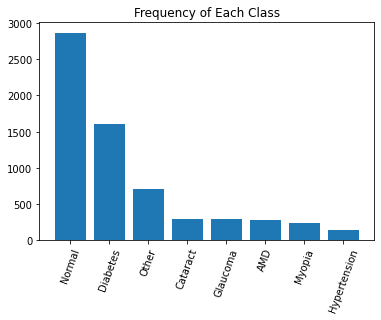

In [5]:
X = [i for i in range(len(full_df['labels'].value_counts()))]

plt.bar(X, full_df['labels'].value_counts(), align='center')
plt.title('Frequency of Each Class')
plt.xticks(X, ['Normal','Diabetes','Other','Cataract','Glaucoma','AMD','Myopia','Hypertension'], rotation=70)

plt.show()

In [6]:
full_df = full_df[full_df['labels'].isin(["['N']","['C']","['M']"])].reset_index()
full_df.head()

,index,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
3,9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg
4,11,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg


In [7]:
# define data directories
image_path = 'archive/preprocessed_images/'

# load data
images, titles = load_data(image_path, list(full_df['filename']))

  0%|          | 16/3398 [00:00<00:21, 159.01it/s]

Loading archive/preprocessed_images/


100%|██████████| 3398/3398 [00:14<00:00, 231.73it/s]


In [8]:
# class_names = {"['N']":0, "['D']":1, "['C']":2, "['G']":3, "['A']":4, "['M']":5, "['H']":6}
class_names = {"['N']":0, "['C']":1, "['M']":2, "['H']":3, "['G']":4, "['D']":5, "['A']":6, "['O']":7}
# class_names = {"['N']":0, "['C']":1, "['G']":2}

labels = list(full_df['labels'].map(class_names))

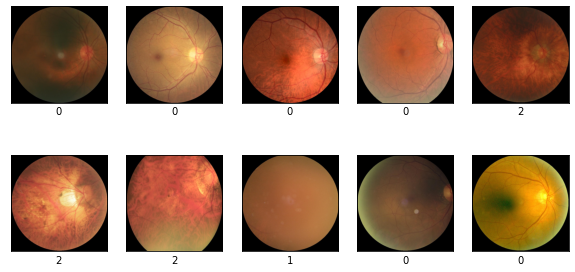

In [9]:
display_images(np.array(images), np.array(labels))

In [10]:
images_filt = []
labels_filt = []
ctr_norm = 0
ctr_diab = 0

for i, l in enumerate(labels):
    if l == 0 and ctr_norm < 300:
        images_filt.append(images[i])
        labels_filt.append(l)
        ctr_norm = ctr_norm + 1
#     if l == 1 and ctr_diab < 300:
#         images_filt.append(images[i])
#         labels_filt.append(l)
#         ctr_diab = ctr_diab + 1
    if l > 0:
        images_filt.append(images[i])
        labels_filt.append(l)
        
print(labels_filt.count(0))
print(labels_filt.count(1))
print(labels_filt.count(2))

300
293
232


In [11]:
train_images, test_images, train_labels, test_labels = train_test_split(np.array(images_filt), 
                                                                        np.array(labels_filt), test_size=0.2)

train = (train_images, train_labels)
test = (test_images, test_labels)

In [12]:
print(np.array(train_images).shape)
print(np.array(test_images).shape)
print(np.array(train_labels).shape)
print(np.array(test_labels).shape)

(660, 512, 512, 3)
(165, 512, 512, 3)
(660,)
(165,)


## Build Model

In [13]:
EPOCHS = 30
BATCH_SIZE = 10
STEPS_PER_EPOCH = len(train_images) // BATCH_SIZE

In [14]:
def normalize(image, label):
    
    input_image = tf.image.resize(image, (128, 128)) / 255.0
    
    # if tf.random.uniform(()) > 0.5:
    input_image = tf.image.adjust_brightness(input_image, 0.3)
    
    return input_image, label

In [15]:
train_set = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_set = train_set.map(normalize)
train_set = train_set.batch(BATCH_SIZE).repeat()

valid_set = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
valid_set = valid_set.map(normalize)
valid_set = valid_set.batch(BATCH_SIZE)

In [16]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu', padding='same', input_shape=(128,128,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(4,4),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.MaxPool2D(4,4),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=48,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(4,4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(240, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        1

In [17]:
LR = 0.00001

model.compile(optimizer=tf.keras.optimizers.Adam(LR), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [18]:
history = model.fit(train_set,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS, validation_data=valid_set)

Epoch 1/30
66/66 [==============================] - 10s 146ms/step - loss: 1.0425 - accuracy: 0.4652 - val_loss: 1.0957 - val_accuracy: 0.3697
Epoch 2/30
66/66 [==============================] - 7s 113ms/step - loss: 0.9281 - accuracy: 0.6455 - val_loss: 1.0903 - val_accuracy: 0.3818
Epoch 3/30
66/66 [==============================] - 7s 113ms/step - loss: 0.8462 - accuracy: 0.7470 - val_loss: 1.0751 - val_accuracy: 0.4364
Epoch 4/30
66/66 [==============================] - 7s 112ms/step - loss: 0.8037 - accuracy: 0.7894 - val_loss: 1.0456 - val_accuracy: 0.4848
Epoch 5/30
66/66 [==============================] - 8s 114ms/step - loss: 0.7546 - accuracy: 0.8409 - val_loss: 0.9823 - val_accuracy: 0.6727
Epoch 6/30
66/66 [==============================] - 8s 114ms/step - loss: 0.7330 - accuracy: 0.8621 - val_loss: 0.8892 - val_accuracy: 0.8061
Epoch 7/30
66/66 [==============================] - 8s 117ms/step - loss: 0.7141 - accuracy: 0.8803 - val_loss: 0.8033 - val_accuracy: 0.8545
Epoch

## Metrics

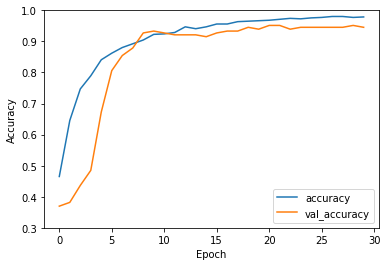

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

plt.show()

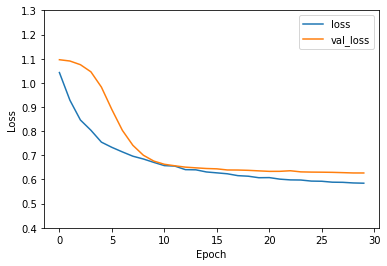

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.4, 1.3])
plt.legend(loc='upper right')

plt.show()

In [21]:
test_loss, test_acc = model.evaluate(valid_set)

17/17 [==============================] - 0s 24ms/step - loss: 0.6269 - accuracy: 0.9455


In [22]:
# classification metrics
pred_labels = []

valid_set = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
valid_set = valid_set.map(normalize).batch(1)

for image, label in tqdm(valid_set):
    predictions = model.predict(image) 
    pred_labels.append(np.argmax(predictions, axis = 1)[0])

165it [00:05, 29.68it/s]


In [31]:
from sklearn.metrics import confusion_matrix, classification_report 

cf = confusion_matrix(test[1], pred_labels)
print(cf)

cr = classification_report(test[1], pred_labels)
print(cr)

[[52  2  2]
 [ 2 58  1]
 [ 0  2 46]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        56
           1       0.94      0.95      0.94        61
           2       0.94      0.96      0.95        48

    accuracy                           0.95       165
   macro avg       0.95      0.95      0.95       165
weighted avg       0.95      0.95      0.95       165



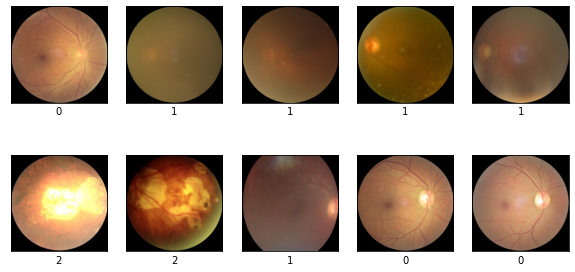

In [32]:
display_images(test_images, pred_labels)